In [19]:
# Get rankings

# NEX yield
nex_yield_rank = pd.merge(nex_yield, gmfd[['log_yield_sim']], left_index=True, right_index=True, how='inner')
nex_yield_rank = nex_yield_rank.rank(axis=1)[['log_yield_sim']]

nex_yield_rank.reset_index(inplace=True)
nex_yield_rank['state'] = nex_yield_rank['fips'].str[:2]

# CMIP yield
cmip_yield_rank = pd.merge(cmip_yield, gmfd[['log_yield_sim']], left_index=True, right_index=True, how='inner')
cmip_yield_rank = cmip_yield_rank.rank(axis=1)[['log_yield_sim']]

cmip_yield_rank.reset_index(inplace=True)
cmip_yield_rank['state'] = cmip_yield_rank['fips'].str[:2]

# NEX GDD
nex_gdd_rank = pd.merge(nex_gdd, gmfd[['gdd']], left_index=True, right_index=True, how='inner')
nex_gdd_rank = nex_gdd_rank.rank(axis=1)[['gdd']]

nex_gdd_rank.reset_index(inplace=True)
nex_gdd_rank['state'] = nex_gdd_rank['fips'].str[:2]

# CMIP GDD
cmip_gdd_rank = pd.merge(cmip_gdd, gmfd[['gdd']], left_index=True, right_index=True, how='inner')
cmip_gdd_rank = cmip_gdd_rank.rank(axis=1)[['gdd']]

cmip_gdd_rank.reset_index(inplace=True)
cmip_gdd_rank['state'] = cmip_gdd_rank['fips'].str[:2]

# NEX EDD
nex_edd_rank = pd.merge(nex_edd, gmfd[['edd']], left_index=True, right_index=True, how='inner')
nex_edd_rank = nex_edd_rank.rank(axis=1)[['edd']]

nex_edd_rank.reset_index(inplace=True)
nex_edd_rank['state'] = nex_edd_rank['fips'].str[:2]

# CMIP EDD
cmip_edd_rank = pd.merge(cmip_edd, gmfd[['edd']], left_index=True, right_index=True, how='inner')
cmip_edd_rank = cmip_edd_rank.rank(axis=1)[['edd']]

cmip_edd_rank.reset_index(inplace=True)
cmip_edd_rank['state'] = cmip_edd_rank['fips'].str[:2]

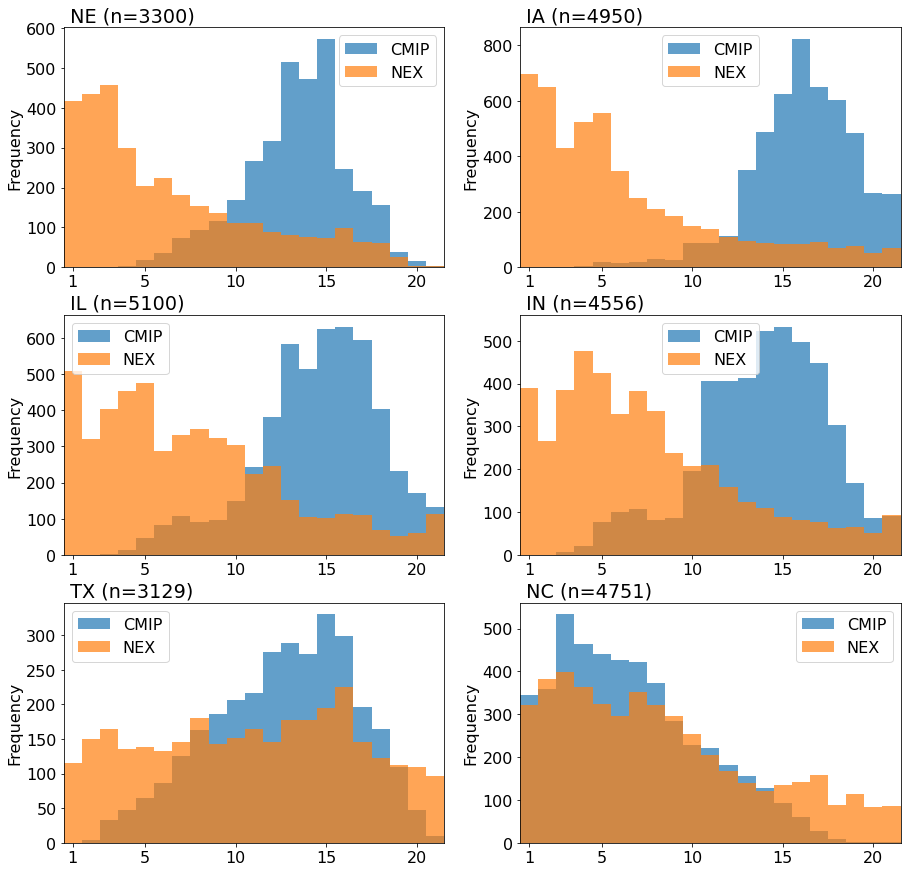

In [21]:
# Plot Nebraska (31), Iowa (19), Illinois (17), Indiana (18), Texas (48), North Carolina (37)
fig, axs = plt.subplots(3,2, figsize=(15,15))
axs=axs.flatten()

# NE
ax=axs[0]
fips='31'
cmip_yield_rank.query('state == "' + fips + '"').plot(y='log_yield_sim', kind='hist', bins=np.arange(1,23,1), label='CMIP', alpha=0.7, ax=ax)
nex_yield_rank.query('state == "' + fips + '"').plot(y='log_yield_sim', kind='hist', bins=np.arange(1,23,1), label='NEX', alpha=0.7, ax=ax)
ax.set_title(' NE (n=' + str(len(nex_yield_rank.query('state == "' + fips + '"'))) + ')', loc = 'left')
ax.set_xlim([1,22])
ax.set_xticks([1.5,5.5,10.5,15.5,20.5])
ax.set_xticklabels(['1','5','10','15','20'])

# IA
ax=axs[1]
fips='19'
cmip_yield_rank.query('state == "' + fips + '"').plot(y='log_yield_sim', kind='hist', bins=np.arange(1,23,1), label='CMIP', alpha=0.7, ax=ax)
nex_yield_rank.query('state == "' + fips + '"').plot(y='log_yield_sim', kind='hist', bins=np.arange(1,23,1), label='NEX', alpha=0.7, ax=ax)
ax.set_title(' IA (n=' + str(len(nex_yield_rank.query('state == "' + fips + '"'))) + ')', loc = 'left')
ax.set_xlim([1,22])
ax.set_xticks([1.5,5.5,10.5,15.5,20.5])
ax.set_xticklabels(['1','5','10','15','20'])

# IA
ax=axs[2]
fips='17'
cmip_yield_rank.query('state == "' + fips + '"').plot(y='log_yield_sim', kind='hist', bins=np.arange(1,23,1), label='CMIP', alpha=0.7, ax=ax)
nex_yield_rank.query('state == "' + fips + '"').plot(y='log_yield_sim', kind='hist', bins=np.arange(1,23,1), label='NEX', alpha=0.7, ax=ax)
ax.set_title(' IL (n=' + str(len(nex_yield_rank.query('state == "' + fips + '"'))) + ')', loc = 'left')
ax.set_xlim([1,22])
ax.set_xticks([1.5,5.5,10.5,15.5,20.5])
ax.set_xticklabels(['1','5','10','15','20'])

# IN
ax=axs[3]
fips='18'
cmip_yield_rank.query('state == "' + fips + '"').plot(y='log_yield_sim', kind='hist', bins=np.arange(1,23,1), label='CMIP', alpha=0.7, ax=ax)
nex_yield_rank.query('state == "' + fips + '"').plot(y='log_yield_sim', kind='hist', bins=np.arange(1,23,1), label='NEX', alpha=0.7, ax=ax)
ax.set_title(' IN (n=' + str(len(nex_yield_rank.query('state == "' + fips + '"'))) + ')', loc = 'left')
ax.set_xlim([1,22])
ax.set_xticks([1.5,5.5,10.5,15.5,20.5])
ax.set_xticklabels(['1','5','10','15','20'])

# TX
ax=axs[4]
fips='48'
cmip_yield_rank.query('state == "' + fips + '"').plot(y='log_yield_sim', kind='hist', bins=np.arange(1,23,1), label='CMIP', alpha=0.7, ax=ax)
nex_yield_rank.query('state == "' + fips + '"').plot(y='log_yield_sim', kind='hist', bins=np.arange(1,23,1), label='NEX', alpha=0.7, ax=ax)
ax.set_title(' TX (n=' + str(len(nex_yield_rank.query('state == "' + fips + '"'))) + ')', loc = 'left')
ax.set_xlim([1,22])
ax.set_xticks([1.5,5.5,10.5,15.5,20.5])
ax.set_xticklabels(['1','5','10','15','20'])

# NC
ax=axs[5]
fips='37'
cmip_yield_rank.query('state == "' + fips + '"').plot(y='log_yield_sim', kind='hist', bins=np.arange(1,23,1), label='CMIP', alpha=0.7, ax=ax)
nex_yield_rank.query('state == "' + fips + '"').plot(y='log_yield_sim', kind='hist', bins=np.arange(1,23,1), label='NEX', alpha=0.7, ax=ax)
ax.set_title(' NC (n=' + str(len(nex_yield_rank.query('state == "' + fips + '"'))) + ')', loc = 'left')
ax.set_xlim([1,22])
ax.set_xticks([1.5,5.5,10.5,15.5,20.5])
ax.set_xticklabels(['1','5','10','15','20'])

plt.legend()
plt.show()

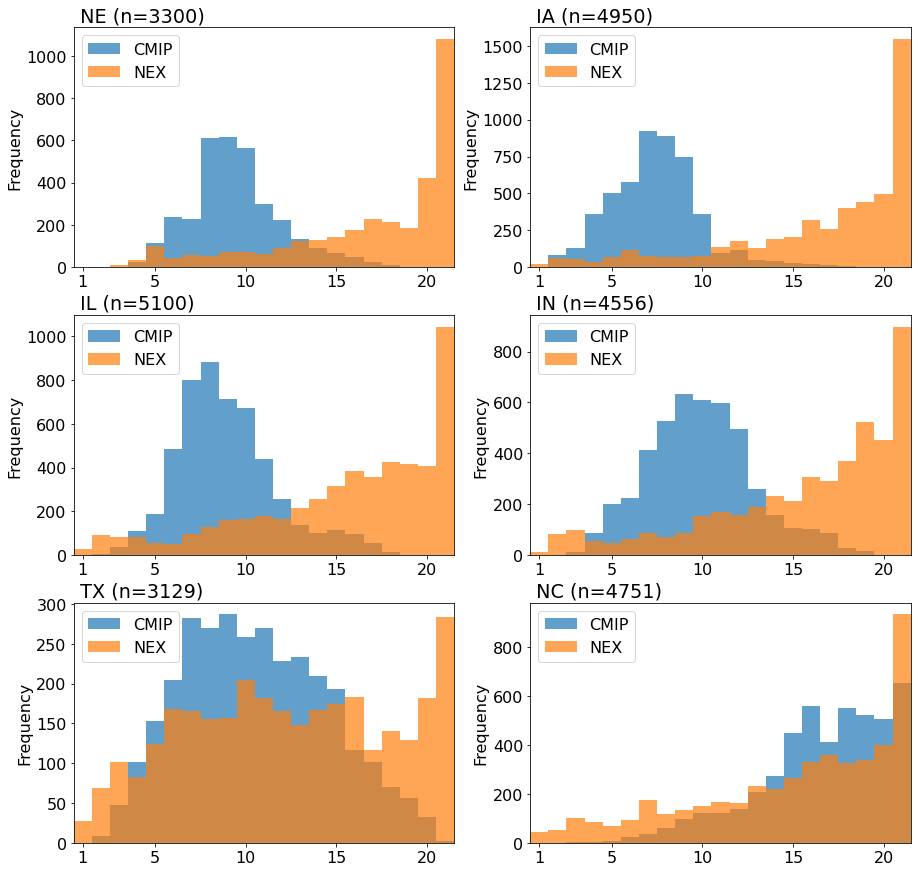

In [22]:
# Plot Nebraska (31), Iowa (19), Illinois (17), Indiana (18), Texas (48), North Carolina (37)
fig, axs = plt.subplots(3,2, figsize=(15,15))
axs=axs.flatten()

# NE
ax=axs[0]
fips='31'
cmip_edd_rank.query('state == "' + fips + '"').plot(y='edd', kind='hist', bins=np.arange(1,23,1), label='CMIP', alpha=0.7, ax=ax)
nex_edd_rank.query('state == "' + fips + '"').plot(y='edd', kind='hist', bins=np.arange(1,23,1), label='NEX', alpha=0.7, ax=ax)
ax.set_title(' NE (n=' + str(len(nex_yield_rank.query('state == "' + fips + '"'))) + ')', loc = 'left')
ax.set_xlim([1,22])
ax.set_xticks([1.5,5.5,10.5,15.5,20.5])
ax.set_xticklabels(['1','5','10','15','20'])

# IA
ax=axs[1]
fips='19'
cmip_edd_rank.query('state == "' + fips + '"').plot(y='edd', kind='hist', bins=np.arange(1,23,1), label='CMIP', alpha=0.7, ax=ax)
nex_edd_rank.query('state == "' + fips + '"').plot(y='edd', kind='hist', bins=np.arange(1,23,1), label='NEX', alpha=0.7, ax=ax)
ax.set_title(' IA (n=' + str(len(nex_yield_rank.query('state == "' + fips + '"'))) + ')', loc = 'left')
ax.set_xlim([1,22])
ax.set_xticks([1.5,5.5,10.5,15.5,20.5])
ax.set_xticklabels(['1','5','10','15','20'])

# IA
ax=axs[2]
fips='17'
cmip_edd_rank.query('state == "' + fips + '"').plot(y='edd', kind='hist', bins=np.arange(1,23,1), label='CMIP', alpha=0.7, ax=ax)
nex_edd_rank.query('state == "' + fips + '"').plot(y='edd', kind='hist', bins=np.arange(1,23,1), label='NEX', alpha=0.7, ax=ax)
ax.set_title(' IL (n=' + str(len(nex_yield_rank.query('state == "' + fips + '"'))) + ')', loc = 'left')
ax.set_xlim([1,22])
ax.set_xticks([1.5,5.5,10.5,15.5,20.5])
ax.set_xticklabels(['1','5','10','15','20'])

# IN
ax=axs[3]
fips='18'
cmip_edd_rank.query('state == "' + fips + '"').plot(y='edd', kind='hist', bins=np.arange(1,23,1), label='CMIP', alpha=0.7, ax=ax)
nex_edd_rank.query('state == "' + fips + '"').plot(y='edd', kind='hist', bins=np.arange(1,23,1), label='NEX', alpha=0.7, ax=ax)
ax.set_title(' IN (n=' + str(len(nex_yield_rank.query('state == "' + fips + '"'))) + ')', loc = 'left')
ax.set_xlim([1,22])
ax.set_xticks([1.5,5.5,10.5,15.5,20.5])
ax.set_xticklabels(['1','5','10','15','20'])

# TX
ax=axs[4]
fips='48'
cmip_edd_rank.query('state == "' + fips + '"').plot(y='edd', kind='hist', bins=np.arange(1,23,1), label='CMIP', alpha=0.7, ax=ax)
nex_edd_rank.query('state == "' + fips + '"').plot(y='edd', kind='hist', bins=np.arange(1,23,1), label='NEX', alpha=0.7, ax=ax)
ax.set_title(' TX (n=' + str(len(nex_yield_rank.query('state == "' + fips + '"'))) + ')', loc = 'left')
ax.set_xlim([1,22])
ax.set_xticks([1.5,5.5,10.5,15.5,20.5])
ax.set_xticklabels(['1','5','10','15','20'])

# NC
ax=axs[5]
fips='37'
cmip_edd_rank.query('state == "' + fips + '"').plot(y='edd', kind='hist', bins=np.arange(1,23,1), label='CMIP', alpha=0.7, ax=ax)
nex_edd_rank.query('state == "' + fips + '"').plot(y='edd', kind='hist', bins=np.arange(1,23,1), label='NEX', alpha=0.7, ax=ax)
ax.set_title(' NC (n=' + str(len(nex_yield_rank.query('state == "' + fips + '"'))) + ')', loc = 'left')
ax.set_xlim([1,22])
ax.set_xticks([1.5,5.5,10.5,15.5,20.5])
ax.set_xticklabels(['1','5','10','15','20'])

plt.legend()
plt.show()

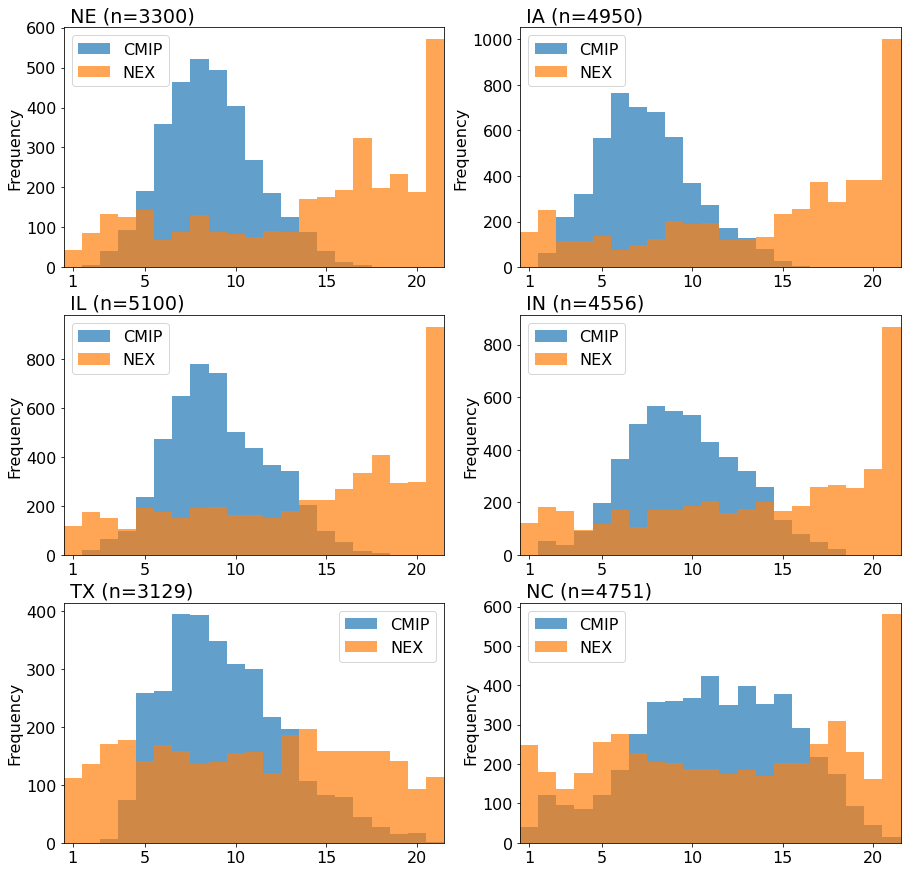

In [23]:
# Plot Nebraska (31), Iowa (19), Illinois (17), Indiana (18), Texas (48), North Carolina (37)
fig, axs = plt.subplots(3,2, figsize=(15,15))
axs=axs.flatten()

# NE
ax=axs[0]
fips='31'
cmip_gdd_rank.query('state == "' + fips + '"').plot(y='gdd', kind='hist', bins=np.arange(1,23,1), label='CMIP', alpha=0.7, ax=ax)
nex_gdd_rank.query('state == "' + fips + '"').plot(y='gdd', kind='hist', bins=np.arange(1,23,1), label='NEX', alpha=0.7, ax=ax)
ax.set_title(' NE (n=' + str(len(nex_yield_rank.query('state == "' + fips + '"'))) + ')', loc = 'left')
ax.set_xlim([1,22])
ax.set_xticks([1.5,5.5,10.5,15.5,20.5])
ax.set_xticklabels(['1','5','10','15','20'])

# IA
ax=axs[1]
fips='19'
cmip_gdd_rank.query('state == "' + fips + '"').plot(y='gdd', kind='hist', bins=np.arange(1,23,1), label='CMIP', alpha=0.7, ax=ax)
nex_gdd_rank.query('state == "' + fips + '"').plot(y='gdd', kind='hist', bins=np.arange(1,23,1), label='NEX', alpha=0.7, ax=ax)
ax.set_title(' IA (n=' + str(len(nex_yield_rank.query('state == "' + fips + '"'))) + ')', loc = 'left')
ax.set_xlim([1,22])
ax.set_xticks([1.5,5.5,10.5,15.5,20.5])
ax.set_xticklabels(['1','5','10','15','20'])

# IA
ax=axs[2]
fips='17'
cmip_gdd_rank.query('state == "' + fips + '"').plot(y='gdd', kind='hist', bins=np.arange(1,23,1), label='CMIP', alpha=0.7, ax=ax)
nex_gdd_rank.query('state == "' + fips + '"').plot(y='gdd', kind='hist', bins=np.arange(1,23,1), label='NEX', alpha=0.7, ax=ax)
ax.set_title(' IL (n=' + str(len(nex_yield_rank.query('state == "' + fips + '"'))) + ')', loc = 'left')
ax.set_xlim([1,22])
ax.set_xticks([1.5,5.5,10.5,15.5,20.5])
ax.set_xticklabels(['1','5','10','15','20'])

# IN
ax=axs[3]
fips='18'
cmip_gdd_rank.query('state == "' + fips + '"').plot(y='gdd', kind='hist', bins=np.arange(1,23,1), label='CMIP', alpha=0.7, ax=ax)
nex_gdd_rank.query('state == "' + fips + '"').plot(y='gdd', kind='hist', bins=np.arange(1,23,1), label='NEX', alpha=0.7, ax=ax)
ax.set_title(' IN (n=' + str(len(nex_yield_rank.query('state == "' + fips + '"'))) + ')', loc = 'left')
ax.set_xlim([1,22])
ax.set_xticks([1.5,5.5,10.5,15.5,20.5])
ax.set_xticklabels(['1','5','10','15','20'])

# TX
ax=axs[4]
fips='48'
cmip_gdd_rank.query('state == "' + fips + '"').plot(y='gdd', kind='hist', bins=np.arange(1,23,1), label='CMIP', alpha=0.7, ax=ax)
nex_gdd_rank.query('state == "' + fips + '"').plot(y='gdd', kind='hist', bins=np.arange(1,23,1), label='NEX', alpha=0.7, ax=ax)
ax.set_title(' TX (n=' + str(len(nex_yield_rank.query('state == "' + fips + '"'))) + ')', loc = 'left')
ax.set_xlim([1,22])
ax.set_xticks([1.5,5.5,10.5,15.5,20.5])
ax.set_xticklabels(['1','5','10','15','20'])

# NC
ax=axs[5]
fips='37'
cmip_gdd_rank.query('state == "' + fips + '"').plot(y='gdd', kind='hist', bins=np.arange(1,23,1), label='CMIP', alpha=0.7, ax=ax)
nex_gdd_rank.query('state == "' + fips + '"').plot(y='gdd', kind='hist', bins=np.arange(1,23,1), label='NEX', alpha=0.7, ax=ax)
ax.set_title(' NC (n=' + str(len(nex_yield_rank.query('state == "' + fips + '"'))) + ')', loc = 'left')
ax.set_xlim([1,22])
ax.set_xticks([1.5,5.5,10.5,15.5,20.5])
ax.set_xticklabels(['1','5','10','15','20'])

plt.legend()
plt.show()

In [73]:
# List of states in order in plot
states = np.array([['38', '55','17'],
         ['46', '27', '18'],
         ['31', '19', '21'],
         ['20', '29', '47'],
         ['40', '05', '28'],
         ['48', '28', '01']])


fips2state = {
        "01": "AL", "02": "AK", "04": "AZ", "05": "AR", "06": "CA",
        "08": "CO", "09": "CT", "10": "DE", "11": "DC", "12": "FL",
        "13": "GA", "15": "HI", "16": "ID", "17": "IL", "18": "IN",
        "19": "IA", "20": "KS", "21": "KY", "22": "LA", "23": "ME",
        "24": "MD", "25": "MA", "26": "MI", "27": "MN", "28": "MS",
        "29": "MO", "30": "MT", "31": "NE", "32": "NV", "33": "NH",
        "34": "NJ", "35": "NM", "36": "NY", "37": "NC", "38": "ND",
        "39": "OH", "40": "OK", "41": "OR", "42": "PA", "44": "RI",
        "45": "SC", "46": "SD", "47": "TN", "48": "TX", "49": "UT",
        "50": "VT", "51": "VA", "53": "WA", "54": "WV", "55": "WI",
        "56": "WY",  # dictionary mapping FIPS code to state abbreviation
    }

In [76]:
nex_yield_rank['state'].unique()

array(['01', '05', '10', '12', '13', '17', '18', '19', '20', '21', '22',
       '24', '26', '27', '28', '29', '31', '34', '36', '37', '38', '39',
       '40', '42', '45', '46', '47', '48', '51', '54', '55'], dtype=object)

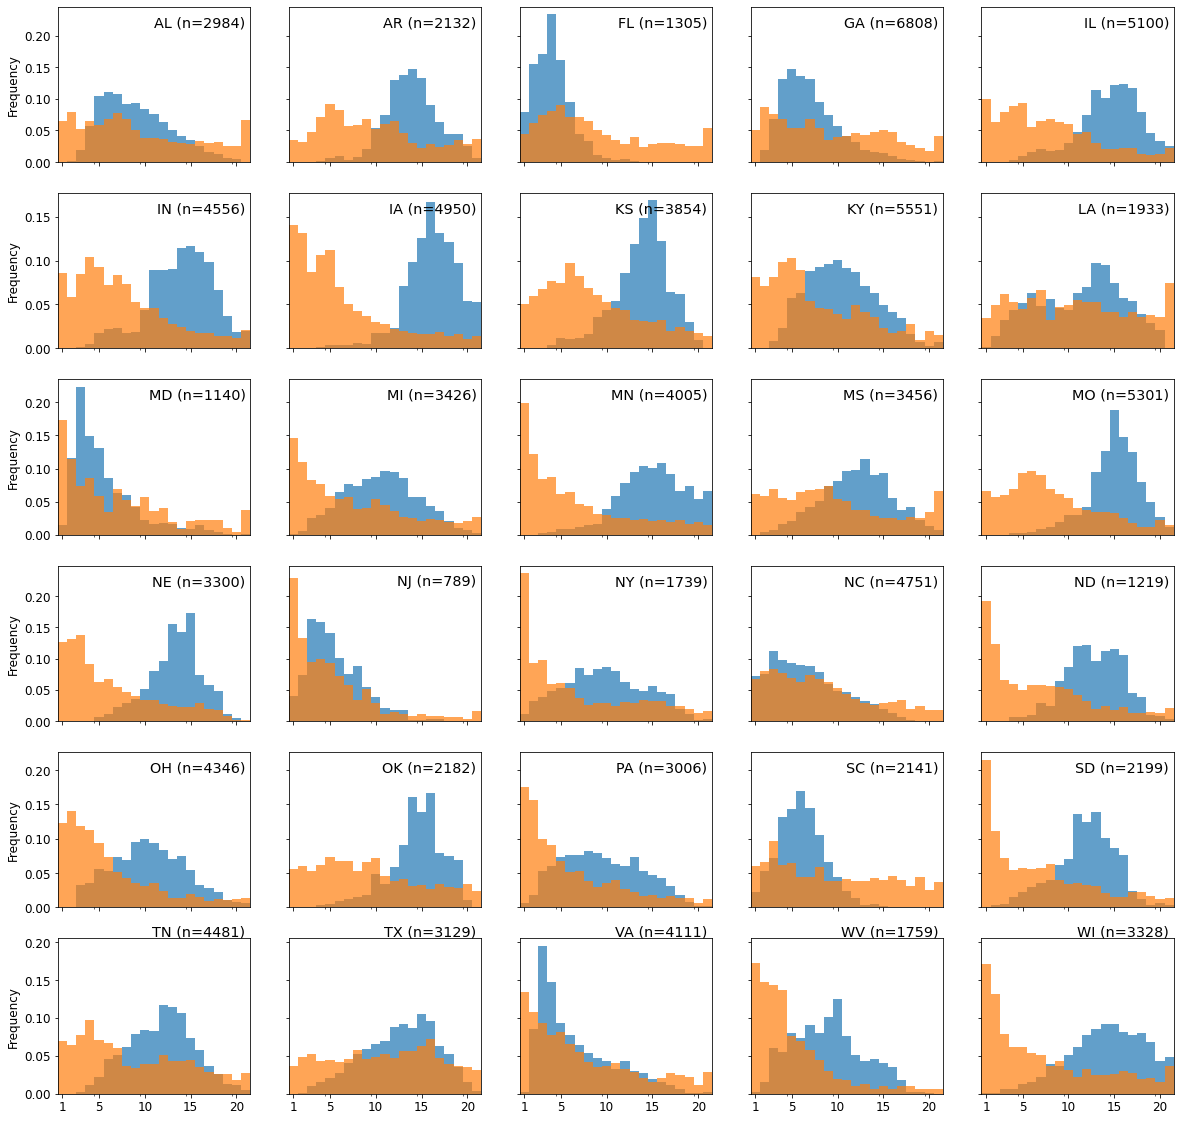

In [79]:
# Plot
fig, axs = plt.subplots(6,5, figsize=(20,20), sharey='row', sharex=True)
axs=axs.flatten()

for index, state in enumerate(np.delete(nex_yield_rank['state'].unique(),2)):
    ax=axs[index]
    fips = state
    cmip_yield_rank.query('state == "' + fips + '"').plot(y='log_yield_sim', kind='hist', bins=np.arange(1,23,1), alpha=0.7, ax=ax, legend=False, density=True)
    nex_yield_rank.query('state == "' + fips + '"').plot(y='log_yield_sim', kind='hist', bins=np.arange(1,23,1), alpha=0.7, ax=ax, legend=False, density=True)
    ax.set_title(fips2state[state] + ' (n=' + str(len(nex_yield_rank.query('state == "' + fips + '"'))) + ') ', loc = 'right', pad=-20)
    ax.set_xlim([1,22])
    ax.set_xticks([1.5,5.5,10.5,15.5,20.5])
    ax.set_xticklabels(['1','5','10','15','20'])

# plt.legend()
plt.show()

In [89]:
import geopandas as gp
# Import plotting shapefiles
county_shp = gp.read_file('../../other/plotting_tools/counties_contig_plot.shp')
county_shp['fips'] = county_shp['fips'].astype(str).str.zfill(5)

# Add State filter for plot
county_shp_plot = county_shp.copy()
county_shp_plot['state'] = county_shp_plot['fips'].str[:2]
county_shp_plot.set_index(['state'], inplace=True)
StateDrop = ['53', '41', '16', '06', '04', '49', '56', '30', '08', '35', '32'] # Western half of CONUS
county_shp_plot = county_shp_plot.drop(StateDrop)

states = gp.read_file('../../other/plotting_tools/states_contig_plot.shp')
coast = gp.read_file('../../other/plotting_tools/coast_contig_plot.shp')

In [225]:
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = -14  # pad is in points...

In [290]:
# Plot function
def get_axis(fig, left, bottom, width=0.09, height=0.09):
    left, bottom, width, height = [left, bottom, width, height]
    return fig.add_axes([left, bottom, width, height])

def plot_state_hist(axis, fips):
    cmip_yield_rank.query('state == "' + fips + '"').plot(y='log_yield_sim', kind='hist', bins=np.arange(1,23,1), alpha=0.7, ax=axis, legend=False, density=True)
    nex_yield_rank.query('state == "' + fips + '"').plot(y='log_yield_sim', kind='hist', bins=np.arange(1,23,1), alpha=0.7, ax=axis, legend=False, density=True)
    axis.set_title('  ' + fips2state[fips], loc='left')
#     ' (n=' + str(len(nex_yield_rank.query('state == "' + fips + '"'))) + ') ', loc = 'right', pad=-20)
    axis.set_xlim([1,22])
#     axis.set_ylim([0,0.2])
    axis.set_ylabel('')
    axis.set_xticks([])
    axis.set_yticks([])

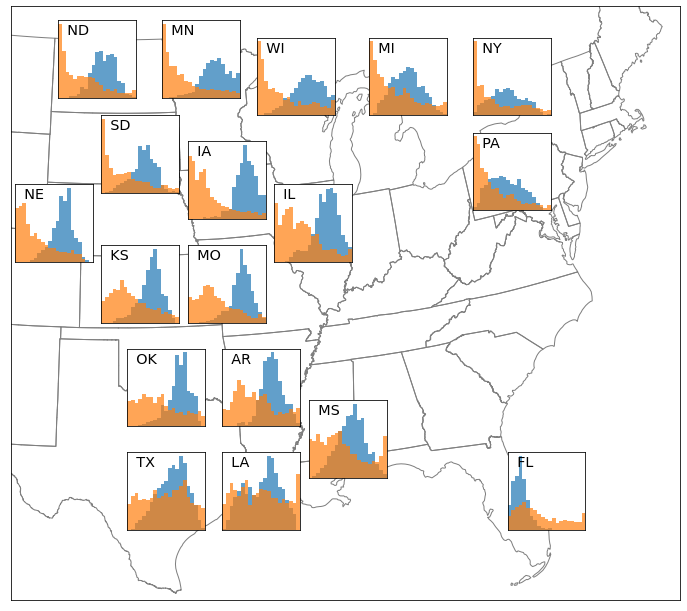

In [316]:
fig, ax = plt.subplots(figsize=(12,12))
states.geometry.boundary.plot(ax=ax, linewidth=1, edgecolor="tab:grey", color=None)
ax.set_ylim([-2150000,600000])
ax.set_xlim([-500000,2600000])

axND = get_axis(fig, 0.18, 0.74)
plot_state_hist(axND, '38')

axSD = get_axis(fig, 0.23, 0.63)
plot_state_hist(axSD, '46')

axNE = get_axis(fig, 0.13, 0.55)
plot_state_hist(axNE, '31')

axKS = get_axis(fig, 0.23, 0.48)
plot_state_hist(axKS, '20')

axOK = get_axis(fig, 0.26, 0.36)
plot_state_hist(axOK, '40')

axTX = get_axis(fig, 0.26, 0.24)
plot_state_hist(axTX, '48')

axMN = get_axis(fig, 0.30, 0.74)
plot_state_hist(axMN, '27')

axIA = get_axis(fig, 0.33, 0.6)
plot_state_hist(axIA, '19')

axMO = get_axis(fig, 0.33, 0.48)
plot_state_hist(axMO, '29')

axAR = get_axis(fig, 0.37, 0.36)
plot_state_hist(axAR, '05')

axLA = get_axis(fig, 0.37, 0.24)
plot_state_hist(axLA, '22')

axWI = get_axis(fig, 0.41, 0.72)
plot_state_hist(axWI, '55')

axMI = get_axis(fig, 0.54, 0.72)
plot_state_hist(axMI, '26')

axNY = get_axis(fig, 0.66, 0.72)
plot_state_hist(axNY, '36')

axFL = get_axis(fig, 0.7, 0.24)
plot_state_hist(axFL, '12')

axIL = get_axis(fig, 0.43, 0.55)
plot_state_hist(axIL, '17')

axPA = get_axis(fig, 0.66, 0.61)
plot_state_hist(axPA, '42')

axMI = get_axis(fig, 0.47, 0.30)
plot_state_hist(axMI, '28')

ax.set_xticks([])
ax.set_yticks([])

# plt.savefig('./test.pdf')
plt.show()

## Figure 1

In [2]:
# Get both ensembles
from combine import combine_nex_yield, combine_cmip_yield
nex_hist = combine_nex_yield()
cmip_hist = combine_cmip_yield()

In [3]:
# Construct national weights (total production by weighted sum of counties)
weights = pd.read_csv('../usda/output/USDA_county_yields_w_county_quad_trends.csv').filter(["GEOID", "year", "area","yield"])
weights["GEOID"] = weights["GEOID"].astype(str).str.zfill(5)
weights.sort_values(by = ['GEOID', 'year'], inplace = True)
weights.set_index(['GEOID', 'year'], inplace = True)
weights["national_weight"] = weights["area"] * weights["yield"]
weights_norm = weights.groupby("year").sum().drop(columns = ["yield", "area"])
# Normalise
weights = pd.merge(weights.reset_index().filter(["GEOID","year","national_weight"]), weights_norm, on = "year")
weights["national_weight"] = weights["national_weight_x"] / weights["national_weight_y"]
weights.drop(columns = ["national_weight_x", "national_weight_y"],inplace=True)
weights = weights.set_index(['GEOID','year']).sort_index()
weights = weights.filter(['national_weight'])

In [4]:
# Interquartile range
def get_iqr(dat):
    return np.quantile(dat, 0.75) - np.quantile(dat, 0.25)

# Silverman bandwidth estimate
def silverman(dat):
    return 0.9 * np.min([np.std(dat), get_iqr(dat)/1.34]) * len(dat)**-0.2

In [5]:
##################################################################################################
include_p05 = False ################# If True, only counties with F-test p-value < 0.05 are included
include_loo = True ################# If True, only counties with LOO CV improvement are included
if include_p05:
    p05_counties = pd.read_csv('../ag_model/fit_model/ag_model_coeff_final.csv').query('pval < 0.05')['GEOID'].astype(str).str.zfill(5).unique()
    weights = weights.loc[p05_counties]
elif include_loo:
    p05_counties = pd.read_csv('../ag_model/fit_model/loo_yes.csv')['GEOID'].astype(str).str.zfill(5).unique()
    weights = weights.loc[p05_counties]
##################################################################################################

# Yield (weighted by production)
nex_weighted = pd.merge(nex_hist.reset_index(), weights.reset_index(), left_on = ['GEOID','Year'], right_on = ['GEOID','year'], how = 'inner').drop(columns = ['year'])
for model in nex_weighted.columns[2:-1]:
    nex_weighted[model] = nex_weighted[model] * nex_weighted['national_weight']
nex_weighted = nex_weighted.groupby(['Year']).sum()

cmip_weighted = pd.merge(cmip_hist.reset_index(), weights.reset_index(), left_on = ['GEOID','Year'], right_on = ['GEOID','year'], how = 'inner').drop(columns = ['year'])
for model in cmip_weighted.columns[2:-1]:
    cmip_weighted[model] = cmip_weighted[model] * cmip_weighted['national_weight']
cmip_weighted = cmip_weighted.groupby(['Year']).sum()

# # Ensembles
# NEXens_w = nex_weighted.drop(columns = ['GMFD', 'national_weight']).to_numpy().flatten()
# CMIPens_w = cmip_weighted.drop(columns = ['GMFD', 'national_weight']).to_numpy().flatten()
# GMFDens_w = nex_weighted.filter(['GMFD']).to_numpy().flatten()

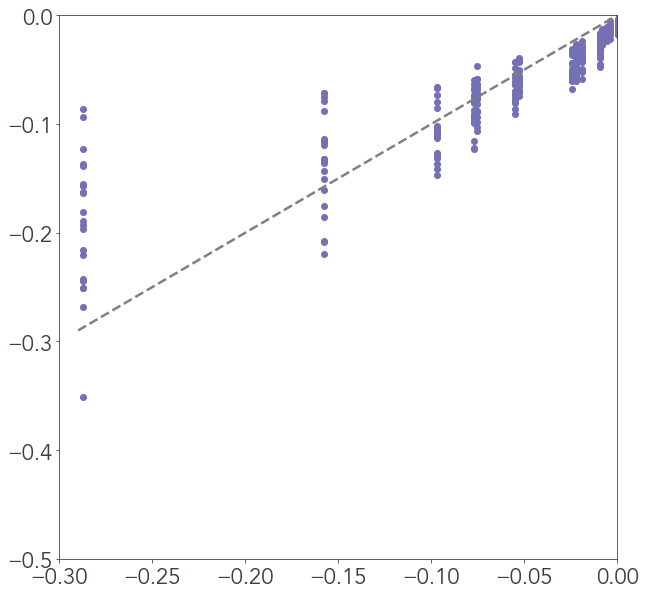

In [85]:
fig, ax = plt.subplots(figsize=(10,10))

for model in cmip_weighted.columns[:-2]:
#     ax.scatter(np.sort(cmip_weighted['GMFD']),np.sort(cmip_weighted[model]), color = '#d95f02')
    ax.scatter(np.sort(nex_weighted['GMFD']),np.sort(nex_weighted[model]), color = '#7570b3')

spacing = np.linspace(-0.29,0.1,100)
ax.plot(spacing, spacing, ls='--', color='gray', lw=2.5)
ax.set_xlim([-0.3,0])
ax.set_ylim([-0.5,0])
plt.show()

In [114]:
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, **kwargs)

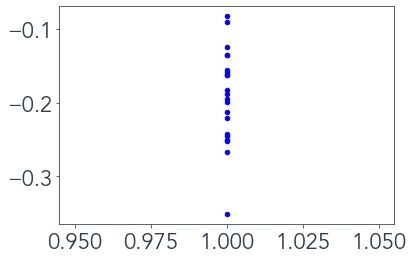

In [115]:
jitter([1]*21, nex_weighted.drop(columns=['national_weight', 'GMFD']).min(axis=0))

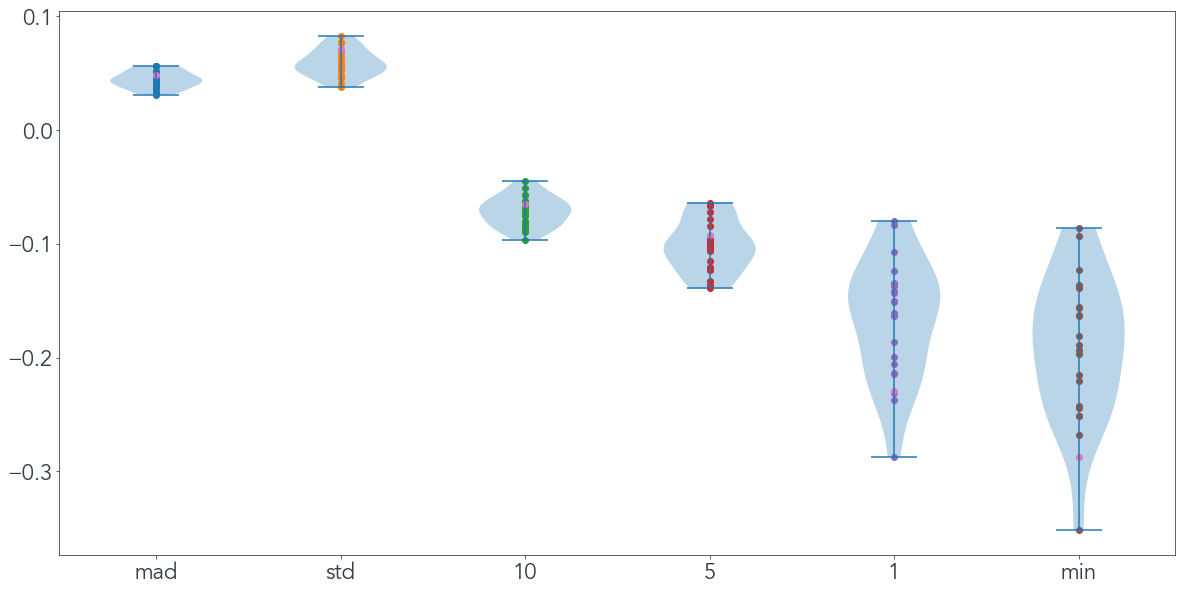

In [119]:
fig, ax = plt.subplots(figsize=(20,10))

ax.violinplot([nex_weighted.drop(columns=['national_weight','GMFD']).mad(axis=0),
            nex_weighted.drop(columns=['national_weight', 'GMFD']).std(axis=0),
            nex_weighted.drop(columns=['national_weight', 'GMFD']).quantile(q=0.1, axis=0),
            nex_weighted.drop(columns=['national_weight', 'GMFD']).quantile(q=0.05, axis=0),
            nex_weighted.drop(columns=['national_weight', 'GMFD']).quantile(q=0.01, axis=0),
           nex_weighted.drop(columns=['national_weight', 'GMFD']).min(axis=0)])


ax.scatter([1]*21, nex_weighted.drop(columns=['national_weight', 'GMFD']).mad(axis=0))
ax.scatter([2]*21, nex_weighted.drop(columns=['national_weight', 'GMFD']).std(axis=0))
ax.scatter([3]*21, nex_weighted.drop(columns=['national_weight', 'GMFD']).quantile(q=0.1, axis=0))
ax.scatter([4]*21, nex_weighted.drop(columns=['national_weight', 'GMFD']).quantile(q=0.05, axis=0))
ax.scatter([5]*21, nex_weighted.drop(columns=['national_weight', 'GMFD']).quantile(q=0.01, axis=0))
ax.scatter([6]*21, nex_weighted.drop(columns=['national_weight', 'GMFD']).min(axis=0))

ax.scatter([1,2,3,4,5,6],
       [nex_weighted['GMFD'].mad(),
       nex_weighted['GMFD'].std(),
       nex_weighted['GMFD'].quantile(q=0.1),
       nex_weighted['GMFD'].quantile(q=0.05),
       nex_weighted['GMFD'].quantile(q=0.01),
       nex_weighted['GMFD'].min()])

ax.set_xticks([1,2,3,4,5,6])
ax.set_xticklabels(labels=['mad','std','10','5','1','min'])
plt.show()

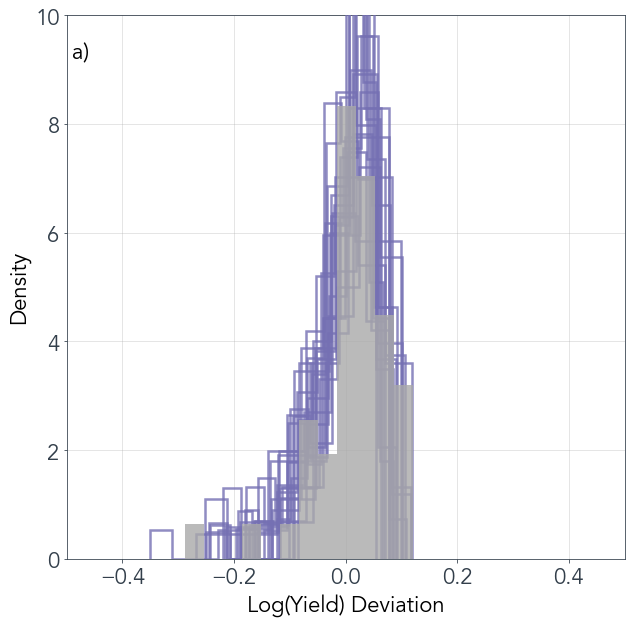

In [82]:
fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams['font.size'] = 22

# PDF
# cmip_weighted.drop(columns = ['national_weight', 'GMFD']).plot(kind='hist', legend=None, histtype='step', bins='fd', label = 'CMIP', color = '#d95f02', linewidth=2.5, density=True, ax=ax, alpha=0.6, zorder=10)
nex_weighted.drop(columns = ['national_weight', 'GMFD']).plot(kind='hist', legend=None, histtype='step', bins='fd', label = 'NEX-GDDP', color = '#7570b3', linewidth=2.5, density=True, ax=ax, alpha=0.8, zorder=10)
ax.hist(GMFDens_w, label = 'Obs.', color = 'darkgray', density=True, bins='fd', zorder=20, alpha=0.8)

ax.set_xlabel('Log(Yield) Deviation')
ax.set_ylabel('Density')
ax.text(0.01, 0.92, 'a)', transform=ax.transAxes)
ax.grid(zorder=10, alpha=0.4)
ax.set_ylim([0,10])
ax.set_xlim([-0.5,0.5])

plt.show()

In [18]:
%%time
# Construct CDFs
nexgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(NEXens_w), 3*silverman(NEXens_w), 30)})
cmipgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(CMIPens_w), 3*silverman(CMIPens_w), 30)})
nexgrid.fit(NEXens_w[:, None])
cmipgrid.fit(CMIPens_w[:, None])
print(nexgrid.best_params_['bandwidth'])
print(cmipgrid.best_params_['bandwidth'])
NEX_ens_pdf = KernelDensity(bandwidth=nexgrid.best_params_['bandwidth'])
NEX_ens_pdf.fit(NEXens_w[:, np.newaxis]);
CMIP_ens_pdf = KernelDensity(bandwidth=cmipgrid.best_params_['bandwidth'])
CMIP_ens_pdf.fit(CMIPens_w[:, np.newaxis]);

0.01909519300964212
0.03568534176614341
CPU times: user 2.3 s, sys: 5.89 ms, total: 2.31 s
Wall time: 2.32 s


KernelDensity(bandwidth=0.03568534176614341)

In [19]:
%%time
sampDist = [NEX_ens_pdf.sample(n_samples = 46).flatten() for i in range(50000)]
CsampDist = [CMIP_ens_pdf.sample(n_samples = 46).flatten() for i in range(50000)]

CPU times: user 3.68 s, sys: 36.1 ms, total: 3.72 s
Wall time: 3.73 s


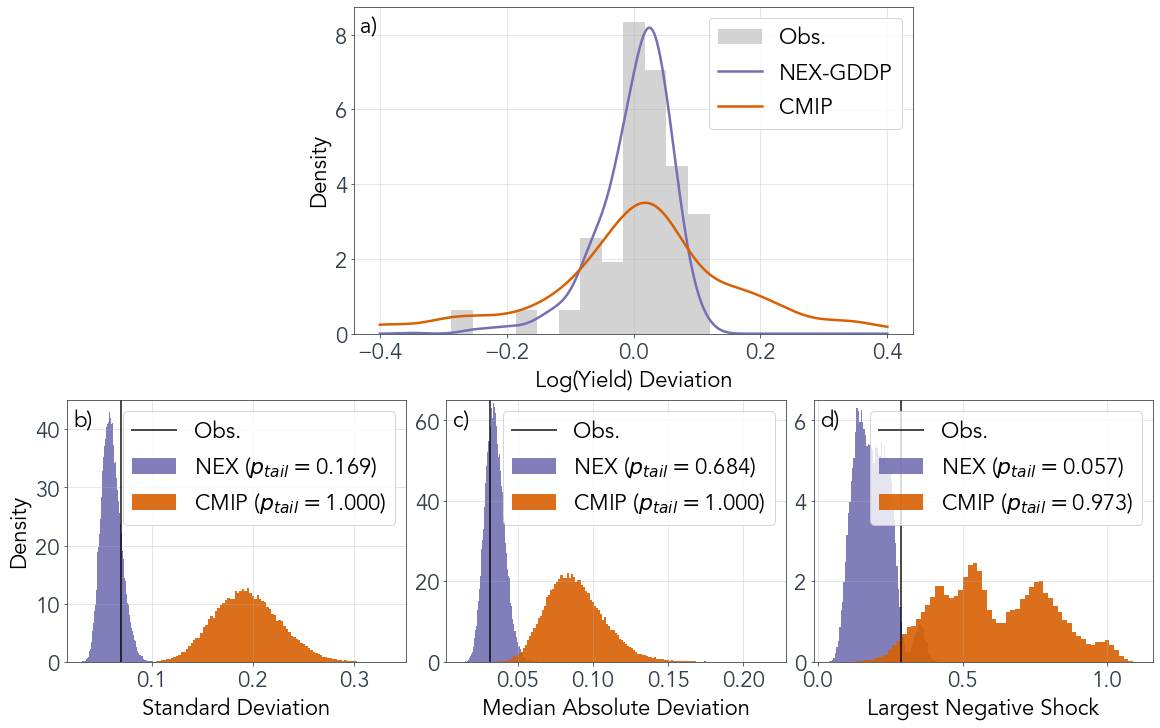

In [31]:
# Final
fig = plt.figure(figsize=(16,10), constrained_layout=True)
gs = gridspec.GridSpec(9, 9, figure=fig)
plt.rcParams['font.size'] = 22

# PDF
ax1 = fig.add_subplot(gs[:5,2:-2])
xarr = np.linspace(-0.4,0.4,1000)
ax1.hist(GMFDens_w, label = 'Obs.', color = 'darkgray', density=True, alpha = 0.5, bins='fd')
ax1.plot(xarr, np.exp(NEX_ens_pdf.score_samples(xarr[:,None])), label = 'NEX-GDDP', color = '#7570b3', linewidth=2.5)
ax1.plot(xarr, np.exp(CMIP_ens_pdf.score_samples(xarr[:,None])), label = 'CMIP', color = '#d95f02', linewidth=2.5)

handles, labels = ax1.get_legend_handles_labels()
order = [2,0,1]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

ax1.set_xlabel('Log(Yield) Deviation')
ax1.set_ylabel('Density')
ax1.text(0.01, 0.92, 'a)', transform=ax1.transAxes)
ax1.grid(zorder=10, alpha=0.4)

# SD
ax2 = fig.add_subplot(gs[-4:, :3])
sampDist1 = np.array([np.std(x) for x in sampDist])
CsampDist1 = np.array([np.std(x) for x in CsampDist])
val = np.std(GMFDens_w)
nex_ecdf = ECDF(sampDist1)
cmip_ecdf = ECDF(CsampDist1)

ax2.hist(sampDist1, density=True,  label = 'NEX ($p_{tail}=$%0.3f)' % (1-nex_ecdf(val)), color = '#7570b3', alpha = 0.9, bins='auto')
ax2.hist(CsampDist1, density=True, label = 'CMIP ($p_{tail}=$%0.3f)' % (1-cmip_ecdf(val)), color = '#d95f02', alpha = 0.9, bins='auto')
ax2.plot([val,val], [0,80], linewidth=2, color = 'black', label = 'Obs.', alpha=0.7)
ax2.set_xlabel('Standard Deviation')
ax2.set_ylabel('Density')
ax2.text(0.02, 0.9, 'b)', transform=ax2.transAxes)
ax2.legend()
ax2.grid(zorder=10, alpha=0.4)
ax2.set_ylim([0,45])

# MAD
ax3 = fig.add_subplot(gs[-4:, 3:6])
sampDist1 = np.array([ss.median_abs_deviation(x) for x in sampDist])
CsampDist1 = np.array([ss.median_abs_deviation(x) for x in CsampDist])
val = ss.median_abs_deviation(GMFDens_w)
nex_ecdf = ECDF(sampDist1)
cmip_ecdf = ECDF(CsampDist1)

ax3.hist(sampDist1, density=True,  label = 'NEX ($p_{tail}=$%0.3f)' % (1-nex_ecdf(val)), color = '#7570b3', alpha = 0.9, bins='auto')
ax3.hist(CsampDist1, density=True, label = 'CMIP ($p_{tail}=$%0.3f)' % (1-cmip_ecdf(val)), color = '#d95f02', alpha = 0.9, bins='auto')
ax3.plot([val,val], [0,80], linewidth=2, color = 'black', label = 'Obs.', alpha=0.7)
ax3.set_xlabel('Median Absolute Deviation')
ax3.text(0.02, 0.9, 'c)', transform=ax3.transAxes)
ax3.legend()
ax3.grid(zorder=10, alpha=0.4)
ax3.set_ylim([0,65])

# Min
ax4 = fig.add_subplot(gs[-4:, 6:])
sampDist1 = np.array([np.abs(np.min(x)) for x in sampDist])
CsampDist1 = np.array([np.abs(np.min(x)) for x in CsampDist])
val = np.abs(np.min(GMFDens_w))
nex_ecdf = ECDF(sampDist1)
cmip_ecdf = ECDF(CsampDist1)

ax4.hist(sampDist1, density=True,  label = 'NEX ($p_{tail}=$%0.3f)' % (1-nex_ecdf(val)), color = '#7570b3', alpha = 0.9, bins='auto')
ax4.hist(CsampDist1, density=True, label = 'CMIP ($p_{tail}=$%0.3f)' % (1-cmip_ecdf(val)), color = '#d95f02', alpha = 0.9, bins='auto')
ax4.plot([val,val], [0,10], linewidth=2, color = 'black', label = 'Obs.', alpha=0.7)
ax4.set_xlabel('Largest Negative Shock')
ax4.text(0.02, 0.9, 'd)', transform=ax4.transAxes)
ax4.legend()
ax4.set_xticks([0.0,0.5,1.0])
ax4.grid(zorder=0, alpha=0.4)
ax4.set_ylim([0,6.5])

# Save
# plt.show()
plt.savefig('../figs/figure1.pdf')